In [8]:
import torch
import numpy as np
from audicor_reader.reader import read_IEC
from evaluation.test_retinanet import test_retinanet
from utils.data_utils import IEC_dataset_preprocessing, onset_offset_generator, normalize
from utils.test_utils import qrs_seperation
from utils.viz_utils import predict_plotter
from model.RetinaNet import RetinaNet
import matplotlib.pyplot as plt
import configparser

config = configparser.ConfigParser()
config.read("config.cfg")
%matplotlib inline

# RetinaNet
## Load Model

In [15]:
# background not included
num_classes = 3
net = RetinaNet(num_classes).cuda()
print(net)
# load pretrained weight
net.load_state_dict(torch.load(config["RetinaNet"]["weight_load_path"]))

RetinaNet(
  (fpn): FPN(
    (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (global_pool): AdaptiveAvgPool1d(output_size=1)
        (conv_down): Conv1d(64, 4, kernel_size=(1,), stride=(1,), bias=False)
        (conv_up): Conv1d(4, 64, kernel_size=(1,), stride=(1,), bias=False)
        (linear_down): Linear(in_features=64, out_features=4, bias=False)
        (linear_up): Linear(in_features=4, out_features=64, bias

<All keys matched successfully>

## Load a new signal for prediction

In [3]:
raw_ekg_sig = []
sig = read_IEC("./data/IEC/IEC_from_audicor/CAL20002_1.raw")
sig = np.reshape(sig[0], (len(sig[0]), 1))
raw_ekg_sig.append(sig.astype(float))
# raw_ekg_sig shape = [#signals, signal_length, 1]

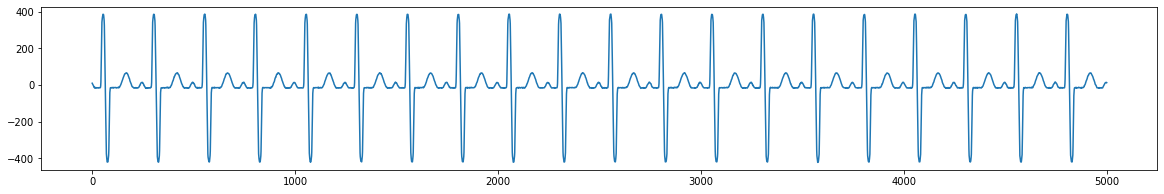

In [4]:
plt.figure(figsize=(20, 3))
plt.plot(raw_ekg_sig[0].reshape(-1))
plt.show()

## Preprocessing the signal

In [5]:
"""
Args:
    smooth: (bool) smooth signal using window averaging
    dns: (bool) denoise signal using wavelet thresholding
"""
ekg_sig = IEC_dataset_preprocessing(raw_ekg_sig, smooth=False, dns=False).to('cuda')
denoise_sig = IEC_dataset_preprocessing(raw_ekg_sig, smooth=False, dns=True).to('cuda')

/mnt/nas/homes/Wr1t3R/.local/share/virtualenvs/unet-AwcyEEfD/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 12 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


## Prediction

In [11]:
final_intervals = []
final_preds = []
denoise_sig = normalize(denoise_sig)
for i in range(denoise_sig.size(0) // 128 + 1):
    plots, intervals, pred_signals = test_retinanet(net, denoise_sig[i*128:(i+1)*128, :, :], 4992, visual=False)
    final_intervals.extend(intervals)
    final_preds.append(pred_signals)
final_preds = torch.cat(final_preds, dim=0)
print(intervals)

[{'p_duration': {'mean': 83.26315789473684, 'var': 17.77285318559557}, 'pq_interval': {'mean': 126.73684210526316, 'var': 4.299168975069253}, 'qrs_duration': {'mean': 101.7, 'var': 4.510000000000002}, 'qt_interval': {'mean': 330.3, 'var': 10.51}}]


## QRS duration prediction

In [12]:
predict = qrs_seperation(ekg_sig, final_preds)
print(predict[0])

{'q_duration': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'r_duration': [24, 25, 26, 25, 26, 24, 25, 25, 24, 25, 25, 25, 25, 24, 24, 24, 24, 24, 24, 24], 's_duration': [25, 25, 25, 25, 25, 25, 25, 25, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25]}


## Visualization

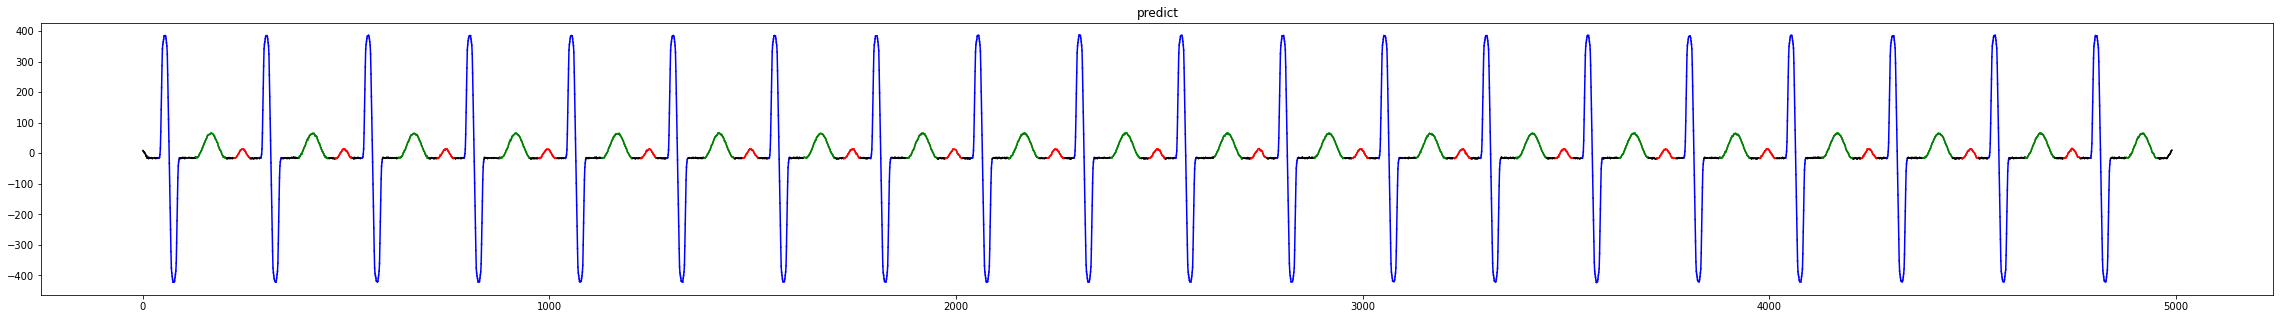

In [13]:
"""
final_preds: [0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0],
            [0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
            [1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0],
4 channels means background, p, qrs, t
"""
plot = predict_plotter(ekg_sig[0][0], final_preds[0])
plot.show()